# Extract water column Sv data at in-situ sensor locations and model the relationship

> disclaimer: This step is compute-intensive and was executed on the high-performance computing (HPC) environment of [VSC](https://www.vscentrum.be/). The preprocessed files generated in previous notebooks were copied onto the storage system of this HPC environment. 

This notebook was ran for each modelled parameter, with its set of suitable campaign data. TVC (TVC1-500µm, TVC1-3µm, TVC3-20µm, TVC20-200µm, TVC200-500µm) was only modeled based on data from campaigns 20-690, 21-430, 21-550_KW and 21-550_WD. The modeling of optical turbidity (in NTU) was based on data from campaigns 20-690, 21-092, 21-160. This notebook includes following steps.
* It configures the HPC cluster that will be used by the Dask scheduler
* It reads the pre-processed in-situ data and prepares it to be matched onto the water column data. This includes:
    * Re-project the coordinates of in-situ measurements to the same CRS as the MBES pointcloud
    * Ensure that the in-situ measurements fall within the octree index of the MBES pointcloud
    * Plot in-situ measurements and MBES pointcloud outlines for visual inspection
* Split the dataset in train and test data
* Build and Sklearn pipeline that:
    * Extracts and averages MBES Sv data in a sphere with a specific radius around the in-situ measurement
    * Imputes missing values 
    * Fits a linear regression model between the in-situ parameter and the Sv data.
* Run the sklearn pipeline using cross-validation to find the optimal radius of the spheres (hyperparameter)
* Print the parameters and plot the regression line for the model with optimal radius
* Asses the R2 of the linear regression model with optimal radius using the test dataset
* Save the linear regression model with optimal radius

In [1]:
import os
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
#from timbers_code.entwine_extract import *

## Set the parameters
* data_files: dictionary with corresponding in-situ sensor (lisst_files) and MBES datasets (entwine_path) to be used in the model
* timbers_data_dir: path to timbers data directory on the HPC environment
* x_coord: the header for the x coordinate of the in-situ sensor 
* y_coord: the header for the y coordinate of the in-situ sensor 
* z_coord: the header for the z coordinate to use for tide correction
* linename: the header that indicates the linename of the MBES coeval to the in-situ measurements (this to avoid extracting MBES measurements from neighboring lines collected at another point in time)
* in_srs: the original spatial reference system of the in-situ data
* out_srs: the spatial reference system of the MBES water column data
* radia: list of radia to test in the cross-validation 
* cross_validation_folds: number of folds in the cross-validation
* x_dimension: header of the independent variable in the linear model
* x_dimension_statistic: statistic of the x_dimension in the extracted sphere to use in modelling
* y_dimension: header of the dependent variable in the linear model
* log_y_dimension: Whether the dependent variable should be logged before fitting the model
* n_workers: Number of worker nodes to use in the HPC cluster
* model_output_file: path where the fitted model with optimal radius will be saved



In [2]:
# data input
data_files = {'lisst_files':["Timbers_20-690/Sensors_20-690_w_grainsize_tide_corrected.csv",
                             "Timbers_21-092/Sensors_21-092_w_grainsize_tide_corrected.csv",
                             "Timbers_21-160/Sensors_21-160_w_grainsize_tide_corrected.csv"],
              'entwine_paths':["Multiingest_0095_6565_20690",
                               "Multiingest_0095_6565_21092",
                               "Multiingest_0095_6565_21160"]}
timbers_data_dir = os.getenv('VSC_DATA_VO')+'/'+os.getenv('USER')+'/timbers/'
data_files['lisst_files'] = [timbers_data_dir+'SENSORS/'+ data_file for data_file in data_files['lisst_files']]
data_files['entwine_paths'] = [timbers_data_dir+'MBES/'+ data_file for data_file in data_files['entwine_paths']]
data_files = pd.DataFrame(data_files)
# set coordinates and spatial reference system to use
x_coord = 'Longitude_ship' #'VPR long' 
y_coord = 'Latitude_ship' #'VPR lat'  
z_coord = 'Lisst_depth_m_LAT'
linename = 'linename'
in_srs = "EPSG:4326" # coordinates of lisst
out_srs =  "EPSG:32631" # coordinates of mbes
# model parameters
radia = np.arange(1.,6.,1.) # number of radia to model
cross_validation_folds = 3 # crossvalidation folds for radius tuning
x_dimension = 'value_db' #x dimension to model
x_dimension_statistic='average' #radius statistic of x dimension to use in modelling
y_dimension = 'Average of Turbidity_NTU'
log_y_dimension = True #if True, all values of y_dimension <= 0 will be dropped and will be logged (base 10)
# number of cluster
n_workers = 40
# output
model_output_file = 'data/models/model_20690_21092_21160_ship'+x_dimension_statistic+'_'+x_dimension+'_vs_'+('Log_'if log_y_dimension else '')+y_dimension.replace(" ", "_")+'_tide_corrected.joblib'

In [3]:
data_files

,lisst_files,entwine_paths
0,/data/gent/vo/001/gvo00125/vsc44608/timbers/SE...,/data/gent/vo/001/gvo00125/vsc44608/timbers/MB...
1,/data/gent/vo/001/gvo00125/vsc44608/timbers/SE...,/data/gent/vo/001/gvo00125/vsc44608/timbers/MB...
2,/data/gent/vo/001/gvo00125/vsc44608/timbers/SE...,/data/gent/vo/001/gvo00125/vsc44608/timbers/MB...


## Configure the cluster settings

In [4]:
from dask_jobqueue import PBSCluster
from dask.distributed import LocalCluster
# when running on PBS Cluster
cluster = PBSCluster(cores=4,
                     processes = 1,
                     memory="4.0gb",
                     walltime="06:00:00",
                     resource_spec="nodes=1:ppn=4",
                     job_extra = ["-l vmem=4gb"],
                     env_extra = ['export PATH="${VSC_DATA}/miniconda3/bin:${PATH}"', 'source activate pcp-env'],
                     scheduler_options={"dashboard_address": ":44000", "host": "gligar08"})
cluster.scale(n_workers)
# when running on local machine
# cluster = LocalCluster() 

/data/gent/446/vsc44608/miniconda3/envs/pcp-env/lib/python3.10/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [5]:
print(cluster.job_script())


#!/usr/bin/env bash

#PBS -N dask-worker
#PBS -l nodes=1:ppn=4
#PBS -l walltime=06:00:00
#PBS -l vmem=4gb
export PATH="${VSC_DATA}/miniconda3/bin:${PATH}"
source activate pcp-env
/data/gent/446/vsc44608/miniconda3/envs/pcp-env/bin/python -m distributed.cli.dask_worker tcp://10.141.10.68:38957 --nthreads 4 --memory-limit 3.73GiB --name dummy-name --nanny --death-timeout 60 --protocol tcp://



In [6]:
from dask.distributed import Client
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.141.10.68:44000/status,
Dashboard: http://10.141.10.68:44000/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.141.10.68:38957,Workers: 0
Dashboard: http://10.141.10.68:44000/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Run the custom python code so that it is available to the dask workers

In [7]:
%run timbers_code/extract_and_model.py

## Prepare the in-situ data
For each campaign do the following:
* read the `lisst_file` into a pandas dataframe
* remove in-situ measurements without coordinates
* clip the lisst point to the zbounds of the MBES pointcloud located at `entwine_path`
* turn into a geopandas dataframe
* reproject to `out_srs`
* clip the in-situ measurements to the outline of the MBES pointcloud located at `entwine_path`
* combine the lisst files into one dataframe and add the related entwine_path

In [8]:
dfs = []
outlines = {}
for lisst_file, entwine_path in data_files.itertuples(index=False):
    # read lisst file
    df = pd.read_csv(lisst_file)
    # drop data missing coordinates
    df = df[~df[[x_coord,y_coord,z_coord,linename]].isna().any(axis = 1)]
    # Filter to Z bounds of Multibeam
    with open(entwine_path+'/ept.json') as f:
        bounds = json.load(f)['boundsConforming']
    minz, maxz = bounds[2],bounds[5]
    df = df[df[z_coord].between(minz, maxz)]
    # FIlter to XY bounds of Multibeam
    # create pandas dataframe with coordinates
    df = gpd.GeoDataFrame(df,geometry = gpd.points_from_xy(df[x_coord],df[y_coord],df[z_coord]))
    # reproject to out_srs
    df = df.set_crs(in_srs).to_crs(out_srs)
    # caclulate outline of of the pointcloud if it doesn't already exist in the entwine path
    if not os.path.exists(entwine_path+'/outline.json'):
        outline = get_outline_from_pointcloud_stream(entwine_path)
        gpd.GeoSeries([outline]).to_file(entwine_path+"/outline.json", driver="GeoJSON")
    else:
        outline = gpd.read_file(entwine_path+'/outline.json').geometry[0]
    # filter point to xy bounds of entwine 
    df = gpd.clip(df,outline)
    # add entwinepath to the df
    df['entwine_path'] = entwine_path
    # add to collections
    dfs.append(df)
    outlines[os.path.basename(entwine_path)] = outline 

/tmp/ipykernel_1540371/480421118.py:5: DtypeWarning: Columns (66,74) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(lisst_file)


In [9]:
df = pd.concat(dfs, ignore_index=True)

### Plot the in-situ measurements that fall within the MBES pointcloud

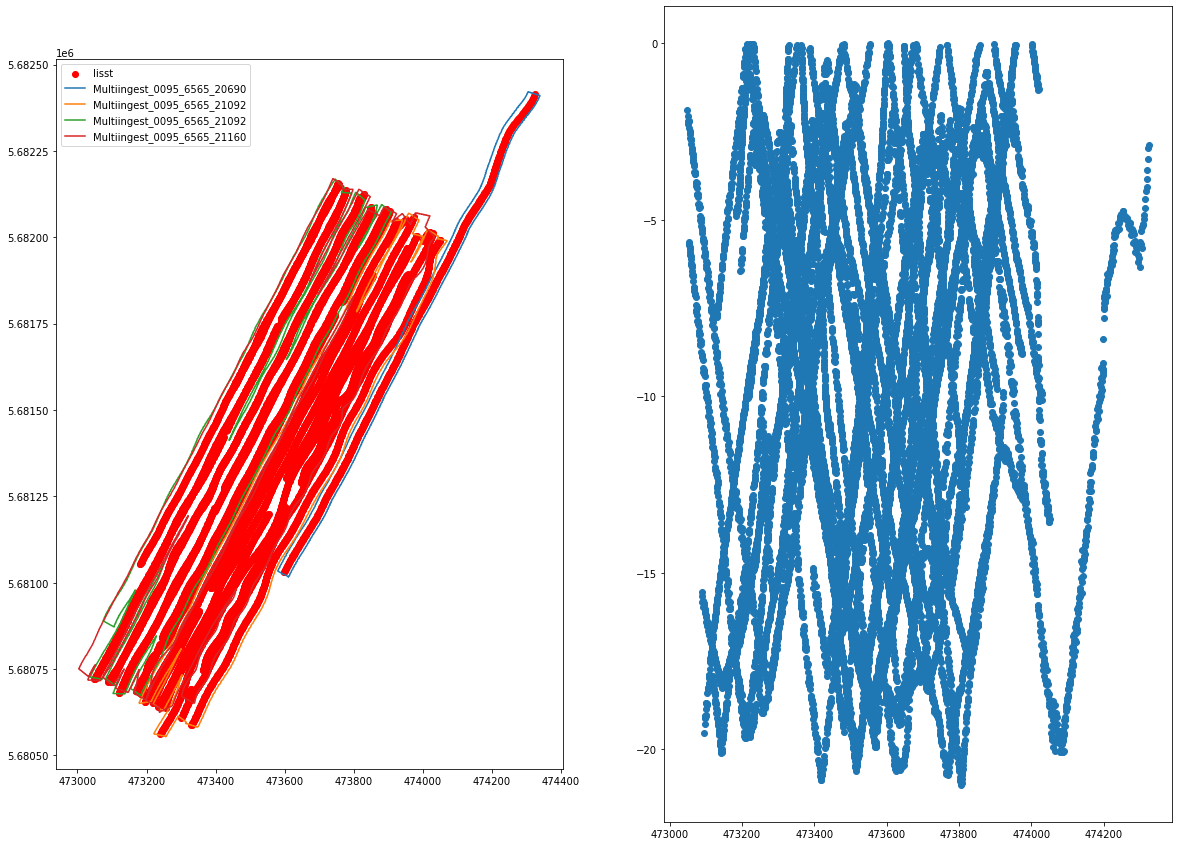

In [10]:
fig,ax = plt.subplots(1, 2,figsize = (20,15))
df.plot(ax=ax[0], color='red', label = 'lisst')
for outline in outlines:
    if outlines[outline].type != 'MultiPolygon' :
        ax[0].plot(*outlines[outline].exterior.xy, label = outline)
    else:
        for polygon in list(outlines[outline].geoms):
            ax[0].plot(*polygon.exterior.xy, label = outline)
ax[0].legend()
ax[1].scatter(x=[geom.x for geom in df.geometry], y = [geom.z for geom in df.geometry])

# Calculate log of y dimension if required

In [11]:
if log_y_dimension:
    # remove all values of y_dimension <= 0 to avoid nans while logging
    df = df[df[y_dimension] > 0].copy()
    df['Log10 '+ y_dimension] = np.log10(df[y_dimension])
    y_dimension = 'Log10 '+ y_dimension

# Split in train and test data set

In [12]:
from sklearn.model_selection import train_test_split as train_test_split_sklearn
from dask_ml.model_selection import train_test_split as train_test_split_dask

In [13]:
df_train, df_test = train_test_split_sklearn(df, test_size = .25, random_state=0)
df_train

,Volume conc (microl/l) 1,Volume conc (microl/l) 2,Volume conc (microl/l) 3,Volume conc (microl/l) 4,Volume conc (microl/l) 5,Volume conc (microl/l) 6,Volume conc (microl/l) 7,Volume conc (microl/l) 8,Volume conc (microl/l) 9,Volume conc (microl/l) 10,...,mode_1,mode_2,mode_3,skewness_geom_um,sorting_geom_um,geometry,entwine_path,"TVC_(20.0, 152.0]",Speed Over Ground,Log10 Average of Turbidity_NTU
9441,NaN,NaN,NaN,NaN,0.001262,0.000000,0.000000,0.003287,0.006334,0.013621,...,72.2,NaN,NaN,-0.819116,2.047393,POINT Z (473220.694 5680867.784 -13.786),/data/gent/vo/001/gvo00125/vsc44608/timbers/MB...,10.188030,NaN,0.696880
10298,NaN,NaN,NaN,NaN,0.001292,0.000000,0.000000,0.003150,0.005991,0.012683,...,72.2,NaN,NaN,-0.854021,2.041984,POINT Z (473150.021 5680749.214 -19.299),/data/gent/vo/001/gvo00125/vsc44608/timbers/MB...,10.269367,NaN,0.640006
1280,NaN,NaN,NaN,NaN,0.002254,0.001125,0.001659,0.006811,0.012811,0.026021,...,43.9,NaN,NaN,-0.378329,2.047159,POINT Z (473942.139 5681997.638 -7.047),/data/gent/vo/001/gvo00125/vsc44608/timbers/MB...,6.931708,NaN,0.243534
8524,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.002630,0.005035,0.010799,...,72.2,NaN,NaN,-0.587218,2.178111,POINT Z (473359.297 5680967.735 -15.321),/data/gent/vo/001/gvo00125/vsc44608/timbers/MB...,6.520436,NaN,0.046105
2254,NaN,NaN,NaN,NaN,0.002662,0.001382,0.002057,0.008272,0.015422,0.030984,...,43.9,NaN,NaN,-0.507092,1.906074,POINT Z (473812.782 5681752.380 -4.897),/data/gent/vo/001/gvo00125/vsc44608/timbers/MB...,5.953692,NaN,0.631444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13932,0.005635,0.017241,0.035511,0.071309,0.116032,0.133938,0.132152,0.181987,0.264211,0.371912,...,85.2,3.11,NaN,-1.251352,2.295650,POINT Z (473660.076 5681510.147 -12.715),/data/gent/vo/001/gvo00125/vsc44608/timbers/MB...,49.476200,3.2,0.926342
3271,NaN,NaN,NaN,NaN,0.002047,0.001012,0.001490,0.006143,0.011638,0.024015,...,51.9,NaN,NaN,-0.495734,2.040708,POINT Z (473606.349 5681865.702 -9.334),/data/gent/vo/001/gvo00125/vsc44608/timbers/MB...,7.022404,NaN,-0.086186
9860,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.002490,0.004966,0.011115,...,61.2,11.70,NaN,-0.608434,2.011907,POINT Z (473272.618 5680795.401 -5.921),/data/gent/vo/001/gvo00125/vsc44608/timbers/MB...,5.260634,NaN,0.535547
10816,NaN,NaN,NaN,NaN,0.002124,0.001074,0.001633,0.006820,0.012826,0.026207,...,37.2,NaN,NaN,-0.544707,1.815160,POINT Z (473235.213 5680640.564 -3.403),/data/gent/vo/001/gvo00125/vsc44608/timbers/MB...,4.811761,NaN,0.211807


## Create the Sklearn pipeline
This fitting pipeline excutes following stpes:
* Extracts data from MBES Sv data at the in-situ measurements location and calculates the `x_dimension_statistic`
* Impute missing values
* Fits a linear regression model between the in-situ parameter and the Sv data.



In [14]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
import statsmodels.api as sm

pipe_parrallel_sm = make_pipeline(EntwineStatsExtractorParrallel(distance= 1.,
                                                                 dimension= x_dimension,
                                                                 statistic = x_dimension_statistic),
                     SimpleImputer(missing_values=np.nan,
                                   strategy='mean',
                                   add_indicator = False), # do not add imputation column
                     SMWrapper(sm.OLS))

## Determine the hyperparameter grid to search over

In [15]:
from sklearn.model_selection import GridSearchCV as GridSearchCV_sklearn
param_grid_parrallel = [{'entwinestatsextractorparrallel__distance': radia}]
gs_sklearn_parrallel_sm = GridSearchCV_sklearn(estimator=pipe_parrallel_sm,
                  param_grid=param_grid_parrallel,
                  scoring='r2',
                  cv=cross_validation_folds,
                  verbose = 3)

# Run cross validation

In [16]:
%%time
gs_sklearn_parrallel_sm.fit(X = df_train[['geometry','entwine_path','linename']],
         y = df_train[y_dimension])

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3] END entwinestatsextractorparrallel__distance=1.0;, score=0.172 total time= 3.4min
[CV 2/3] END entwinestatsextractorparrallel__distance=1.0;, score=0.171 total time= 3.3min


Exception in thread Profile:
Traceback (most recent call last):
  File "/data/gent/446/vsc44608/miniconda3/envs/pcp-env/lib/python3.10/site-packages/distributed/profile.py", line 115, in process
    d = state["children"][ident]
KeyError: '_propagate_forgotten;/data/gent/446/vsc44608/miniconda3/envs/pcp-env/lib/python3.10/site-packages/distributed/scheduler.py;7870'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/data/gent/446/vsc44608/miniconda3/envs/pcp-env/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/data/gent/446/vsc44608/miniconda3/envs/pcp-env/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/data/gent/446/vsc44608/miniconda3/envs/pcp-env/lib/python3.10/site-packages/distributed/profile.py", line 274, in _watch
    process(frame, None, recent, omit=omit)
  File "/data/gent/446/vsc44608/miniconda3/envs/pcp-env/lib/python3.10/s

[CV 3/3] END entwinestatsextractorparrallel__distance=1.0;, score=0.161 total time= 3.5min
[CV 1/3] END entwinestatsextractorparrallel__distance=2.0;, score=0.190 total time= 5.0min
[CV 2/3] END entwinestatsextractorparrallel__distance=2.0;, score=0.189 total time= 5.0min
[CV 3/3] END entwinestatsextractorparrallel__distance=2.0;, score=0.179 total time= 4.7min
[CV 1/3] END entwinestatsextractorparrallel__distance=3.0;, score=0.207 total time= 5.7min
[CV 2/3] END entwinestatsextractorparrallel__distance=3.0;, score=0.205 total time= 5.8min
[CV 3/3] END entwinestatsextractorparrallel__distance=3.0;, score=0.198 total time= 5.8min
[CV 1/3] END entwinestatsextractorparrallel__distance=4.0;, score=0.221 total time= 7.0min
[CV 2/3] END entwinestatsextractorparrallel__distance=4.0;, score=0.216 total time= 7.1min
[CV 3/3] END entwinestatsextractorparrallel__distance=4.0;, score=0.214 total time= 7.0min
[CV 1/3] END entwinestatsextractorparrallel__distance=5.0;, score=0.230 total time= 8.3min

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('entwinestatsextractorparrallel',
                                        EntwineStatsExtractorParrallel(dimension='value_db',
                                                                       distance=1.0,
                                                                       statistic='average')),
                                       ('simpleimputer', SimpleImputer()),
                                       ('smwrapper',
                                        SMWrapper(model_class=<class 'statsmodels.regression.linear_model.OLS'>))]),
             param_grid=[{'entwinestatsextractorparrallel__distance': array([1., 2., 3., 4., 5.])}],
             scoring='r2', verbose=3)

## Print the optimal radius and the parameters of the associated model

In [17]:
print(gs_sklearn_parrallel_sm.best_params_)
print(gs_sklearn_parrallel_sm.best_score_)
gs_sklearn_parrallel_sm.best_estimator_['smwrapper'].results_.summary()

{'entwinestatsextractorparrallel__distance': 5.0}
0.2259567579735149


<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                  
==========================================================================================
Dep. Variable:     Log10 Average of Turbidity_NTU   R-squared:                       0.226
Model:                                        OLS   Adj. R-squared:                  0.226
Method:                             Least Squares   F-statistic:                     3513.
Date:                            Fri, 05 Aug 2022   Prob (F-statistic):               0.00
Time:                                    14:29:20   Log-Likelihood:                -2170.5
No. Observations:                           12024   AIC:                             4345.
Df Residuals:                               12022   BIC:                             4360.
Df Model:                                       1                                         
Covariance Type:                        nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.9788      0.090     66.372      0.000       5.802       6.155
x1             0.0740      0.001     59.268      0.000       0.072       0.076
==============================================================================
Omnibus:                     1163.848   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2027.334
Skew:                          -0.682   Prob(JB):                         0.00
Kurtosis:                       4.479   Cond. No.                     2.46e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.46e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Calculate the score for the model with optimal radius using the test dataset

In [18]:
%%time
gs_sklearn_parrallel_sm.score(X = df_test[['geometry','entwine_path','linename']], y = df_test[[y_dimension]])

CPU times: user 40.6 s, sys: 2.09 s, total: 42.7 s
Wall time: 2min 44s


0.21104907942037032

## Plot the regression line of the model with optimal radius

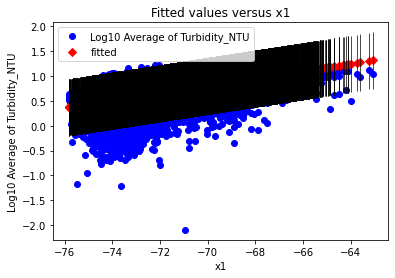

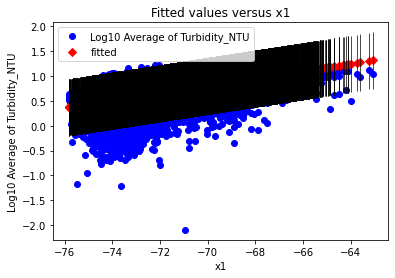

In [19]:
import statsmodels.api as sm
sm.graphics.plot_fit(gs_sklearn_parrallel_sm.best_estimator_['smwrapper'].results_, 'x1')

## Save the model with optimal radius

In [20]:
from joblib import dump, load
dump(gs_sklearn_parrallel_sm.best_estimator_['smwrapper'].results_, model_output_file)

['data/models/model_20690_21092_21160_shipaverage_value_db_vs_Log_Average_of_Turbidity_NTU_tide_corrected.joblib']